## Classify Gestures By Reading EMG Muscle Activity

### Data Description

Four classes of motion were written from MYO armband with the help of our app https://github.com/cyber-punk-me/nukleos.

The MYO armband has 8 sensors placed on skin surface, each measures electrical activity produced by muscles beneath.

Each dataset line has 8 consecutive readings of all 8 sensors. so 64 columns of EMG data. The last column is a resulting gesture that was made while recording the data (classes 0-3)

Each line has the following structure:

[8sensors][8sensors][8sensors][8sensors][8sensors][8sensors][8sensors][8sensors][GESTURE_CLASS]

Data was recorded at 200 Hz, which means that each line is 8*(1/200) seconds = 40ms of record time.

A classifier given 64 numbers would predict a gesture class (0-3)

Gesture classes were : rock - 0, scissors - 1, paper - 2, ok - 3. Rock, paper, scissors gestures are like in the game with the same name, and OK sign is index finger touching the thumb and the rest of the fingers spread. Gestures were selected pretty much randomly.

Each gesture was recorded 6 times for 20 seconds. Each time recording started with the gesture being already prepared and held. Recording stopped while the gesture was still being held. In total there is 120 seconds of each gesture being held in fixed position. All of them recorded from the same right forearm in a short timespan. Every recording of a certain gesture class was concatenated into a .csv file with a corresponding name (0-3).

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/emg-4/0.csv
/kaggle/input/emg-4/1.csv
/kaggle/input/emg-4/2.csv
/kaggle/input/emg-4/3.csv


In [2]:
# Import packages

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# load datasets into pandas dataframes

r0 = pd.read_csv('/kaggle/input/emg-4/0.csv', header=None)
s1 = pd.read_csv('/kaggle/input/emg-4/1.csv', header=None)
p2 = pd.read_csv('/kaggle/input/emg-4/2.csv', header=None)
o3 = pd.read_csv('/kaggle/input/emg-4/3.csv', header=None)

In [4]:
# look at dataframe shapes

print('Class 0 Shape: ', r0.shape)
print('Class 1 Shape: ', s1.shape)
print('Class 2 Shape: ', p2.shape)
print('Class 3 Shape: ', o3.shape)

Class 0 Shape:  (2910, 65)
Class 1 Shape:  (2903, 65)
Class 2 Shape:  (2943, 65)
Class 3 Shape:  (2922, 65)


In [5]:
# Concat the dataframes vertically into one

df = pd.concat([r0,s1,p2,o3])

In [6]:
print(df.shape)

(11678, 65)


In [7]:
# Check for null values

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11678 entries, 0 to 2921
Data columns (total 65 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       11678 non-null  float64
 1   1       11678 non-null  float64
 2   2       11678 non-null  float64
 3   3       11678 non-null  float64
 4   4       11678 non-null  float64
 5   5       11678 non-null  float64
 6   6       11678 non-null  float64
 7   7       11678 non-null  float64
 8   8       11678 non-null  float64
 9   9       11678 non-null  float64
 10  10      11678 non-null  float64
 11  11      11678 non-null  float64
 12  12      11678 non-null  float64
 13  13      11678 non-null  float64
 14  14      11678 non-null  float64
 15  15      11678 non-null  float64
 16  16      11678 non-null  float64
 17  17      11678 non-null  float64
 18  18      11678 non-null  float64
 19  19      11678 non-null  float64
 20  20      11678 non-null  float64
 21  21      11678 non-null  float64
 22 

In [8]:
# create numpy array 'data' and make sure data array has intended structure

data = df.values
print(type(data))
print(len(data))
print(len(data[0]))
print(data[0:20])

<class 'numpy.ndarray'>
11678
65
[[ 26.   4.   5. ... -59.  16.   0.]
 [-47.  -6.  -5. ... 111.  15.   0.]
 [-19.  -8.  -8. ... 114.  48.   0.]
 ...
 [-84.  -7.   0. ... -55.   4.   0.]
 [  8.  -7.  -3. ... -12.   9.   0.]
 [ 26.   4.   1. ... -21.  -2.   0.]]


In [9]:
# create a scaler for plotting
sc = MinMaxScaler(feature_range = (0,1))

In [10]:
# create a function for reformatting the data and plotting by label and sensor signal

def plot_data(data):
    
    # Four empty lists, one for each class
    x0 = []
    x1 = []
    x2 = []
    x3 = []
    
    for i in range(data.shape[0]):
        temp = data[i,:-1].reshape((8,8))
        for j in range(8):
            if data[i, -1] == 0:
                x0.append(temp[j,:])
            elif data[i, -1] == 1:
                x1.append(temp[j,:])
            elif data[i, -1] == 2:
                x2.append(temp[j,:])
            elif data[i,-1] == 3:
                x3.append(temp[j,:])
                
    x0 = np.array(x0)
    x1 = np.array(x1)
    x2 = np.array(x2)
    x3 = np.array(x3)
    
    fig, axes = plt.subplots(4,8, figsize=(30,8), sharex=True, sharey=True)
    
    for i in range(8):
        axes[0][i].plot(x0[:,i], label='Raw Ch '+str(i))
        axes[1][i].plot(x1[:,i], label='Raw Ch '+str(i))
        axes[2][i].plot(x2[:,i], label='Raw Ch '+str(i))
        axes[3][i].plot(x3[:,i], label='Raw Ch '+str(i))
    

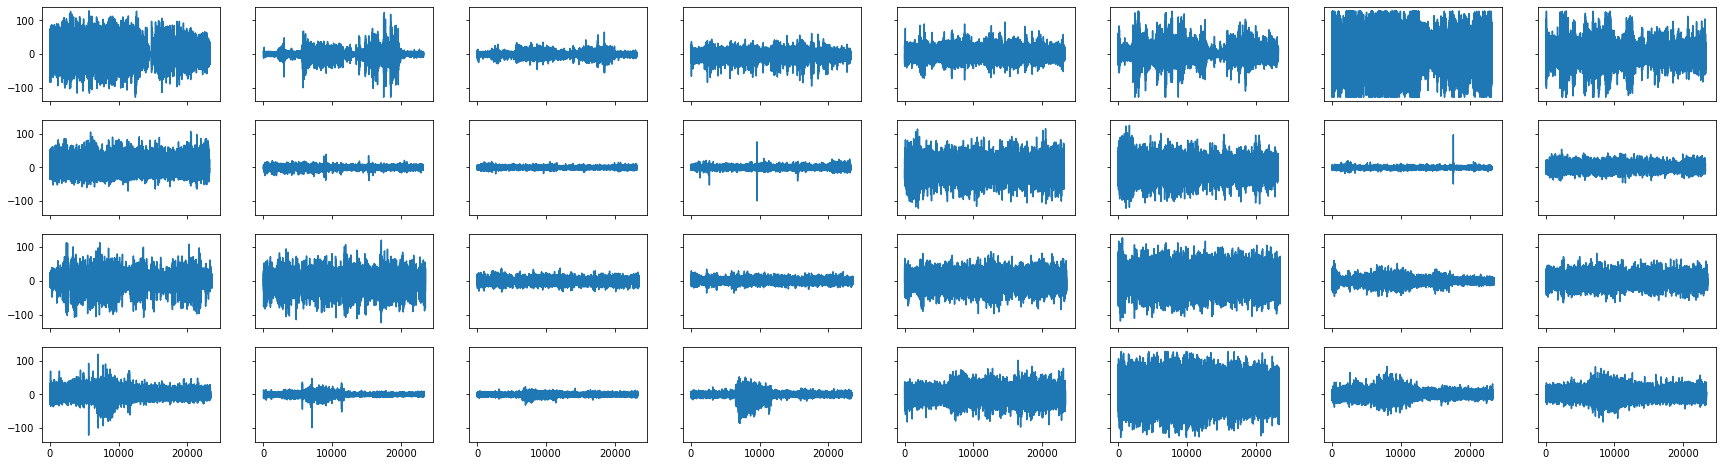

In [11]:
plot_data(data)

In [12]:
# Build Neural Net Model

class ClickNet(nn.Module):
    
    def __init__(self, n__features, n_hidden, n_sequence, n_layers, n_classes):
        
        super(ClickNet, self).__init__()
        self.n_features = n_features
        self.n_hidden = n_hidden
        self.n_sequence = n_sequence
        self.n_layers = n_layers
        self.n_classes = n_classes
        
        self.lstm = nn.LSTM(input_size=n_features, hidden_size=n_hidden, num_layers=n_layers, batch_first=True)
        self.linear_1 = nn.Linear(in_features=n_hidden, out_features=128)
        self.dropout_1 = nn.Dropout(p=0.2)
        self.linear_2 = nn.Linear(in_features=128, out_features=n_classes)
        
    def forward(self, x):
        
        self.hidden = (
            torch.zeros(self.n_layers, x.shape[0], self.n_hidden).to(device),
            torch.zeros(self.n_layers, x.shape[0], self.n_hidden).to(device)
                       )
        
        out, (hs, cs) = self.lstm(x.view(len(x), self.n_sequence, -1), self.hidden)
        out = out[:,-1,:]
        out = self.linear_1(out)
        out = self.dropout_1(out)
        out = self.linear_2(out)
        
        return out
    

In [13]:
# Define Function for model training

def train_model(model, train_dataloader, n_epochs):
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        
    for epoch in range(n_epochs):
        for i, (X_train, y_train) in enumerate(train_dataloader):
            y_pred = model(X_train)
            loss = loss_fn(y_pred.float(), y_train)
                
            if i == 0 and (epoch+1)%10==0:
                print('Epoch: ', epoch+1, ' train loss: ', loss.item())
                    
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
                
                
    return model        

In [14]:
# Possibly try one hot encoding of target labels

def one_hot(a):
    a=a.astype(int)
    b = np.zeros((a.size, a.max()+1))
    b[np.arange(a.size),a] = 1
    return b

In [15]:
# function to prepare data
# Scale data between 0 and 1 (except the target column)
# Shuffle values randomly
# Split into feature and target arrays
# Add last dimension to feature array - needed to be accepted by neural network
# Split into train and testing sets and convert numpy arrays into torch tensors (70% train, 30% test split)

def prepare_data(data):
    data[:,:-1] = sc.fit_transform(data[:,:-1])
    np.random.shuffle(data)
    X, y = data[:,:-1], data[:,-1]
    X = X.reshape(-1,8,8)
    # y = onehot(y)
    
    X_train = torch.from_numpy(X[:7700])
    y_train = torch.from_numpy(y[:7700])
    X_test = torch.from_numpy(X[7700:])
    y_test = torch.from_numpy(y[7700:])
    
    return X_train.float().to(device), y_train.long().to(device), X_test.float().to(device), y_test.long().to(device)



In [16]:
# Define class to return properties of the dataset

class EMGDataSet(Dataset):
    
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __getitem__(self, index):
        return self.X[index], self.y[index]
    
    def __len__(self):
        return self.X.shape[0]
    

In [18]:
# Initialize and run model

n_features = 8
n_sequence = 8
n_hidden = 64
n_layers = 1
n_classes = 4
n_epochs = 500
n_batch_size = 256

model = ClickNet(n_features, n_hidden, n_sequence, n_layers, n_classes).to(device)
X_train, y_train, X_test, y_test = prepare_data(data)

print('Training Data Shape: ', X_train.shape, y_train.shape)
print('Test Data Shape: ', X_test.shape, y_test.shape)

train_dataset = EMGDataSet(X_train, y_train)
train_dataloader = DataLoader(dataset = train_dataset, batch_size = n_batch_size, shuffle=True)
model = train_model(model, train_dataloader, n_epochs = n_epochs)

Training Data Shape:  torch.Size([7700, 8, 8]) torch.Size([7700])
Test Data Shape:  torch.Size([3978, 8, 8]) torch.Size([3978])
Epoch:  10  train loss:  1.3721256256103516
Epoch:  20  train loss:  1.3843226432800293
Epoch:  30  train loss:  1.38445246219635
Epoch:  40  train loss:  1.3813245296478271
Epoch:  50  train loss:  1.3382768630981445
Epoch:  60  train loss:  1.177998423576355
Epoch:  70  train loss:  1.1588150262832642
Epoch:  80  train loss:  1.0522757768630981
Epoch:  90  train loss:  0.9394102096557617
Epoch:  100  train loss:  0.9686744213104248
Epoch:  110  train loss:  0.9240240454673767
Epoch:  120  train loss:  0.9664363265037537
Epoch:  130  train loss:  0.9556683301925659
Epoch:  140  train loss:  0.8437995910644531
Epoch:  150  train loss:  0.9758442640304565
Epoch:  160  train loss:  0.7577774524688721
Epoch:  170  train loss:  0.7666996121406555
Epoch:  180  train loss:  0.7252281308174133
Epoch:  190  train loss:  0.9757124185562134
Epoch:  200  train loss:  0.5

In [20]:
# Evaluate model, make predictions

def evaluateModel(prediction, y):
    prediction = torch.argmax(prediction, dim=1)
    ok = 0
    for i in range(len(y)):
        if (prediction[i] == y[i]):
            ok = ok+1
    return (ok/len(y))*100

with torch.no_grad():
    y_pred_train = model(X_train)
    print('Train set Accuracy: ', evaluateModel(y_pred_train, y_train))
    
    y_pred_test = model(X_test)
    print('Test Accuracy: ', evaluateModel(y_pred_test, y_test))

Train set Accuracy:  97.84415584415585
Test Accuracy:  93.01156359979889
